# Develop Fan Chart Vis
Trying to produce a nice fan chart visualization to compare the magnitude of variability between systems, relative to the mean value in particular.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
colors = {
    'CalCS': '#80b1d3',
    'HumCS': '#fb8072',
    'CanCS': '#fdb462',
    'BenCS': '#bc80bd'
}

# Decomposition Plots

In [3]:
EBU = 'CalCS'
VAR = 'FG_CO2'
fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/' + VAR + '/' + EBU + '/filtered_output/'
ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-AW-chavez-800km.nc')
ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-AW-chavez-800km.nc')

In [4]:
ds_total = ds_residuals + ds_forced

In [ ]:
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(311)
ds_total['FG_CO2_AW'][0].plot(color=colors[EBU])
ax1.set_title('Total FG_CO2 (S001)', fontsize=18)
ax2 = fig.add_subplot(312)
ds_forced['FG_CO2_AW'].plot(color=colors[EBU])
ax2.set_title('Ensemble Mean FG_CO2', fontsize=18)
ax3 = fig.add_subplot(313)
ds_residuals['FG_CO2_AW'][0].plot(color=colors[EBU])
ax3.set_title('Residual FG_CO2 (S001)', fontsize=18)
#plt.savefig(EBU + '-FG_CO2-timeseries-decomposition.png')

# Fan Plots

In [92]:
# Load in ensemble.
EBU = 'BenCS'
VAR = 'pCO2SURF'
###
fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/' + VAR + '/' + EBU + '/filtered_output/'
ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-AW-chavez-800km.nc')
ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-AW-chavez-800km.nc')
ds_total = ds_residuals + ds_forced

In [93]:
total_data = ds_total[VAR + '_AW'].values
total_data = np.sort(total_data, axis=0) # Sorts from least to most at each time step for the ensemble. 
resid_data = ds_residuals[VAR + '_AW'].values
resid_data = np.sort(resid_data, axis=0)

In [94]:
# Will store reference values for the fan chart.
tot_inner_50, tot_inner_80, tot_total = ({} for i in range(3))
res_inner_50, res_inner_80, res_total = ({} for i in range(3))

# Total Simulated Variable
tot_total['lower'] = total_data[0]
tot_total['upper'] = total_data[33]
# Inner 80%
tot_inner_80['lower'] = total_data[3]
tot_inner_80['upper'] = total_data[30]
# Inner 50%
tot_inner_50['lower'] = total_data[8]
tot_inner_50['upper'] = total_data[25]

# Residuals of Simulated Variable
res_total['lower'] = resid_data[0]
res_total['upper'] = resid_data[33]
# Inner 80%
res_inner_80['lower'] = resid_data[3]
res_inner_80['upper'] = resid_data[30]
# Inner 50%
res_inner_50['lower'] = resid_data[8]
res_inner_50['upper'] = resid_data[25]

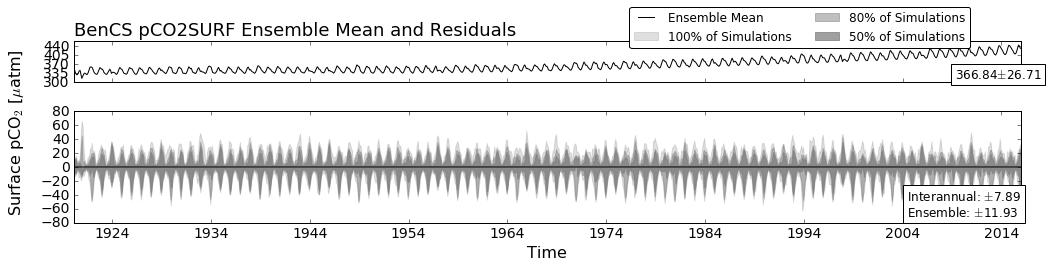

In [95]:
x = ds_forced['time'].values
y_tot = ds_forced[VAR + '_AW']
y_res = ds_residuals[VAR + '_AW'].mean(dim='ensemble')
fig = plt.figure(figsize=(14,8))

# Y label
if VAR == 'SST':
    y_label = "Temperature [$^{o}$C]"
elif VAR == 'FG_CO2':
    y_label = "CO$_{2}$ Flux [mol/m$^{2}$/yr]"
elif VAR == 'pCO2SURF':
    y_label = "Surface pCO$_{2}$ [$\mu$atm]"

# Set up subplots
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
ax1 = plt.subplot2grid((3, 1), (0, 0))
ax2 = plt.subplot2grid((3, 1), (1, 0), rowspan=2)

# Ensemble mean on top subplot
l1 = ax1.plot(x, y_tot, color='k')
ax1.xaxis.set_ticklabels([]) # Remove x labels
ymin, ymax = ax1.get_ylim()
if VAR == 'FG_CO2':
    ax1.yaxis.set_ticks(np.arange(ymin, ymax+1, 1))
elif VAR == 'SST':
    ax1.yaxis.set_ticks(np.arange(ymin, ymax+1, 2))
elif VAR == 'pCO2SURF':
    ax1.yaxis.set_ticks(np.arange(ymin, ymax+1, 35))
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_title(EBU + ' ' + VAR + ' Ensemble Mean and Residuals', loc='left',
             fontsize=18)

# Summary Statistics
mean = np.mean(y_tot.values)
std = np.std(y_tot.values)
ax1.annotate(str(mean.round(2)) + '$\pm$' + str(std.round(2)), xy=(0.93, 0.1), xycoords='axes fraction',
              bbox=dict(facecolor='w', edgecolor='k'), fontsize=12)

# Residual Fan Chart on bottom subplot.
ax2.fill_between(x, res_total['upper'], res_total['lower'], color='gray', alpha=0.25, label='100% of Simulations')
ax2.fill_between(x, res_inner_80['upper'], res_inner_80['lower'], color='gray', alpha=0.5, label='80% of Simulations')
ax2.fill_between(x, res_inner_50['upper'], res_inner_50['lower'], color='gray', alpha=0.75, label='50% of Simulations')
ax2.plot(x, y_res, '-k', label='Ensemble Mean')
ax2.set_xlabel('Time', fontsize=16)
ax2.set_ylabel('')
ax2.tick_params(axis='both', which='major', labelsize=14)

# Summary Statistics
ens_spread = np.mean(np.std(resid_data, axis=0))
interannual = np.mean(np.std(resid_data, axis=1))
ax2.annotate('Interannual: $\pm$' + str(interannual.round(2)) + '\n' + 'Ensemble: $\pm$' +
             str(ens_spread.round(2)), xy=(0.88, 0.06), xycoords='axes fraction',
            bbox=dict(facecolor='w', edgecolor='k'), fontsize=12)

# Legend
ax2.legend(loc='center left', bbox_to_anchor=(0.58, 1.75),
          ncol=2, fancybox=True, shadow=False)

# Label full plot
ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.ylabel(y_label, fontsize=16)
ax.yaxis.set_label_coords(-0.05,0.5)

fig.tight_layout(pad=1.5)

# SAVE FIGURE!
directory = '/glade/u/home/rbrady/projects/EBUS_BGC_Variability/reports/figs/' + EBU.lower() + '/mean_and_residuals/'
plt.savefig(directory + EBU.lower() + '-' + VAR + '-historical-signal-and-noise.png', format='png', dpi=900)